In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import keras
import pandas as pd

data = pd.read_csv("cumulative.csv")

In [2]:
data.describe().round(2)  # round to 2 decimal places

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9564.00,9564.00,8054.00,9564.00,9564.00,9564.00,9564.00,9564.00,9110.00,9110.00,...,9081.00,9201.00,9096.00,9096.00,9201.00,9096.00,9096.00,9564.00,9564.00,9563.00
mean,4782.50,7690628.33,0.48,0.19,0.23,0.19,0.12,75.67,0.00,-0.00,...,-162.27,4.31,0.12,-0.14,1.73,0.36,-0.39,292.06,43.81,14.26
std,2761.03,2653459.08,0.48,0.39,0.42,0.40,0.33,1334.74,0.01,0.01,...,72.75,0.43,0.13,0.09,6.13,0.93,2.17,4.77,3.60,1.39
min,1.00,757450.00,0.00,0.00,0.00,0.00,0.00,0.24,0.00,-0.17,...,-1762.00,0.05,0.00,-1.21,0.11,0.00,-116.14,279.85,36.58,6.97
25%,2391.75,5556034.25,0.00,0.00,0.00,0.00,0.00,2.73,0.00,-0.00,...,-198.00,4.22,0.04,-0.20,0.83,0.13,-0.25,288.66,40.78,13.44
50%,4782.50,7906892.00,0.33,0.00,0.00,0.00,0.00,9.75,0.00,-0.00,...,-160.00,4.44,0.07,-0.13,1.00,0.25,-0.11,292.26,43.68,14.52
75%,7173.25,9873066.50,1.00,0.00,0.00,0.00,0.00,40.72,0.00,-0.00,...,-114.00,4.54,0.15,-0.09,1.34,0.36,-0.07,295.86,46.71,15.32
max,9564.00,12935144.00,1.00,1.00,1.00,1.00,1.00,129995.78,0.17,0.00,...,0.00,5.36,1.47,0.00,229.91,33.09,0.00,301.72,52.34,20.00


In [3]:
# helper functions for data cleaning
def remove_uneed_cols(x, koi_score_col=True):
    # search for meta data columns 
    meta_data = x.select_dtypes(include=["object"]).columns
    # search for err columns
    err_columns = x.columns[x.columns.str.contains("err")]
    koi_score_col = "koi_score"

    # from cols that contain id
    id_cols = [col for col in x.columns if col.endswith("id")]

    if koi_score_col:
        # drop koi_score_col and all the other columns
        drop_list =  [koi_score_col] + list(meta_data) + list(err_columns) + list(id_cols)
    else:
        drop_list = ["koi_disposition"] + list(meta_data) + list(err_columns) + list(id_cols)

    needed_cols = [col for col in x.columns if col not in drop_list]
    x = x[needed_cols]
    return x


# find percentage missing values in each column
def find_missing_values(x):
    missing_values = x.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values = missing_values / len(x) * 100
    return missing_values.round(2)



In [4]:
data = pd.read_csv("cumulative.csv")
data.describe()
# if koi_disposition is "CONFIRMED" then we assign true to the target variable else false
data['koi_disposition']= data["koi_disposition"].apply(lambda x: 1 if x == "CONFIRMED" else 0).astype("int")

In [5]:
data = remove_uneed_cols(data)
missing = find_missing_values(data)
print(missing)
data = data.dropna()


koi_impact          3.80
koi_depth           3.80
koi_prad            3.80
koi_teq             3.80
koi_insol           3.36
koi_model_snr       3.80
koi_tce_plnt_num    3.62
koi_steff           3.80
koi_slogg           3.80
koi_srad            3.80
koi_kepmag          0.01
dtype: float64


In [6]:
# drop rows with missing values
x = data.drop(columns=["koi_disposition"])
y = data["koi_disposition"]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# For numerical features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import keras_tuner as kt
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_model(hp):
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[x_train.shape[1]]))
    
    # Tune number of units in first dense layer
    hp_units1 = hp.Int('units1', min_value=192, max_value=576, step=64)
    model.add(keras.layers.Dense(hp_units1, activation="relu"))
    
    # Tune dropout rate
    hp_dropout1 = hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(hp_dropout1))
    
    # Tune number of units in second dense layer
    hp_units2 = hp.Int('units2', min_value=64, max_value=250, step=32)
    model.add(keras.layers.Dense(hp_units2, activation="relu"))
    
    # Tune dropout rate
    hp_dropout2 = hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(hp_dropout2))
    
    # Output layer for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['precision', 'accuracy']
    )
    
    return model



In [9]:
import os
import pickle
from tensorflow.keras.callbacks import Callback

# Custom callback to save history during tuning
class SaveTunerHistory(Callback):
    def __init__(self, trial_id, save_dir='tuner_histories'):
        super(SaveTunerHistory, self).__init__()
        self.trial_id = trial_id
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
    def on_train_end(self, logs=None):
        # Save the history for this trial
        with open(f"{self.save_dir}/history_trial_{self.trial_id}.pkl", 'wb') as f:
            pickle.dump(self.model.history.history, f)

# Modify the tuner.search method to add the custom callback
class MyTuner(kt.GridSearch):
    def run_trial(self, trial, *args, **kwargs):
        # Get the trial_id
        trial_id = trial.trial_id
        
        # Add our custom callback to save history
        callbacks = kwargs.get('callbacks', [])
        callbacks.append(SaveTunerHistory(trial_id))
        kwargs['callbacks'] = callbacks
        
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Create the custom tuner
tuner = MyTuner(
    build_model,
    objective='val_accuracy',
    max_trials=25,
    directory='keras_tuner',
    project_name='binary_classification'
)



early_stopping_loss = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',  # 'min' because we want to minimize loss
    restore_best_weights=True # this will restore the best weights based on the monitored metric
)


reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    mode='min',
    min_lr=1e-6,
    verbose=1
)

# Start the search
tuner.search(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping_loss, 
               reduce_lr_loss],
    verbose=1
)

Trial 25 Complete [00h 00m 24s]
val_accuracy: 0.8563443422317505

Best val_accuracy So Far: 0.8932364583015442
Total elapsed time: 00h 06m 37s


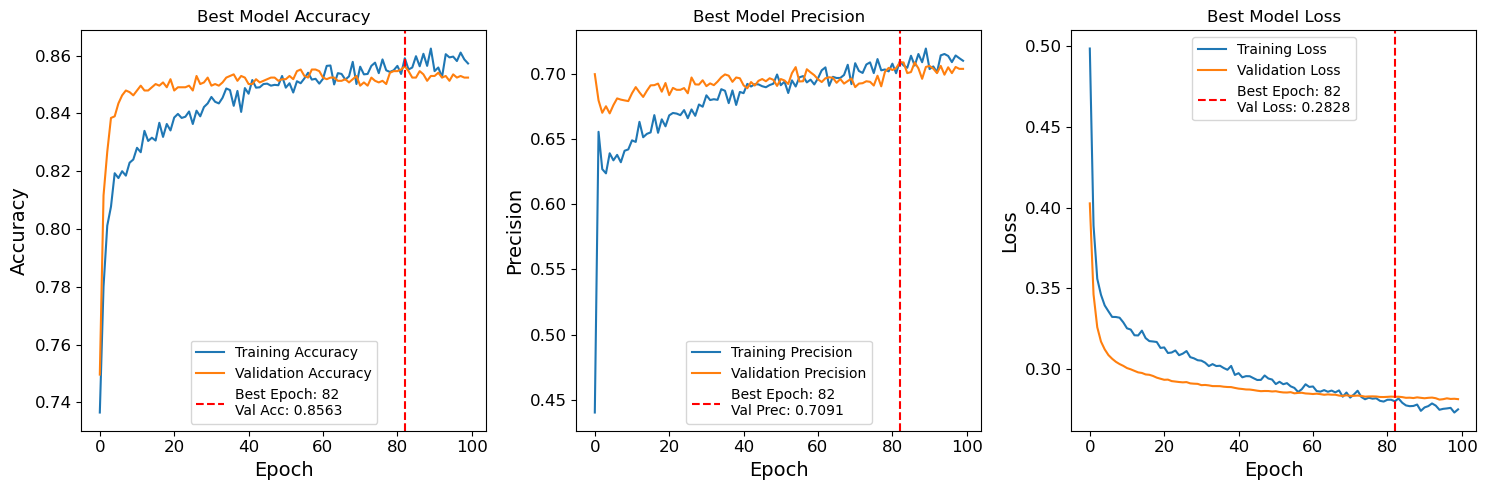

In [10]:
# Load history files after tuning
import glob
import pickle

# List all saved history files
history_files = glob.glob('tuner_histories/history_trial_*.pkl')

# Find the best trial ID
best_trial_id = tuner.oracle.get_best_trials(num_trials=1)[0].trial_id
best_history_file = f'tuner_histories/history_trial_{best_trial_id}.pkl'

# Load the best trial's history
with open(best_history_file, 'rb') as f:
    best_history = pickle.load(f)

# Get the best epoch after the first 5 epochs
best_epoch = np.argmax(best_history['val_accuracy'])

# Now plot the best trial's history
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add vertical line for best epoch with metrics in legend
plt.axvline(x=best_epoch, color='r', linestyle='--', 
            label=f'Best Epoch: {best_epoch}\nVal Acc: {best_history["val_accuracy"][best_epoch]:.4f}')
plt.legend()

# Plot training & validation precision
plt.subplot(1, 3, 2)
plt.plot(best_history['precision'], label='Training Precision')
plt.plot(best_history['val_precision'], label='Validation Precision')
plt.title('Best Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
# Add vertical line for best epoch with metrics
plt.axvline(x=best_epoch, color='r', linestyle='--', 
            label=f'Best Epoch: {best_epoch}\nVal Prec: {best_history["val_precision"][best_epoch]:.4f}')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 3, 3)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', 
            label=f'Best Epoch: {best_epoch}\nVal Loss: {best_history["val_loss"][best_epoch]:.4f}')
plt.legend()

plt.tight_layout()
plt.show()




/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


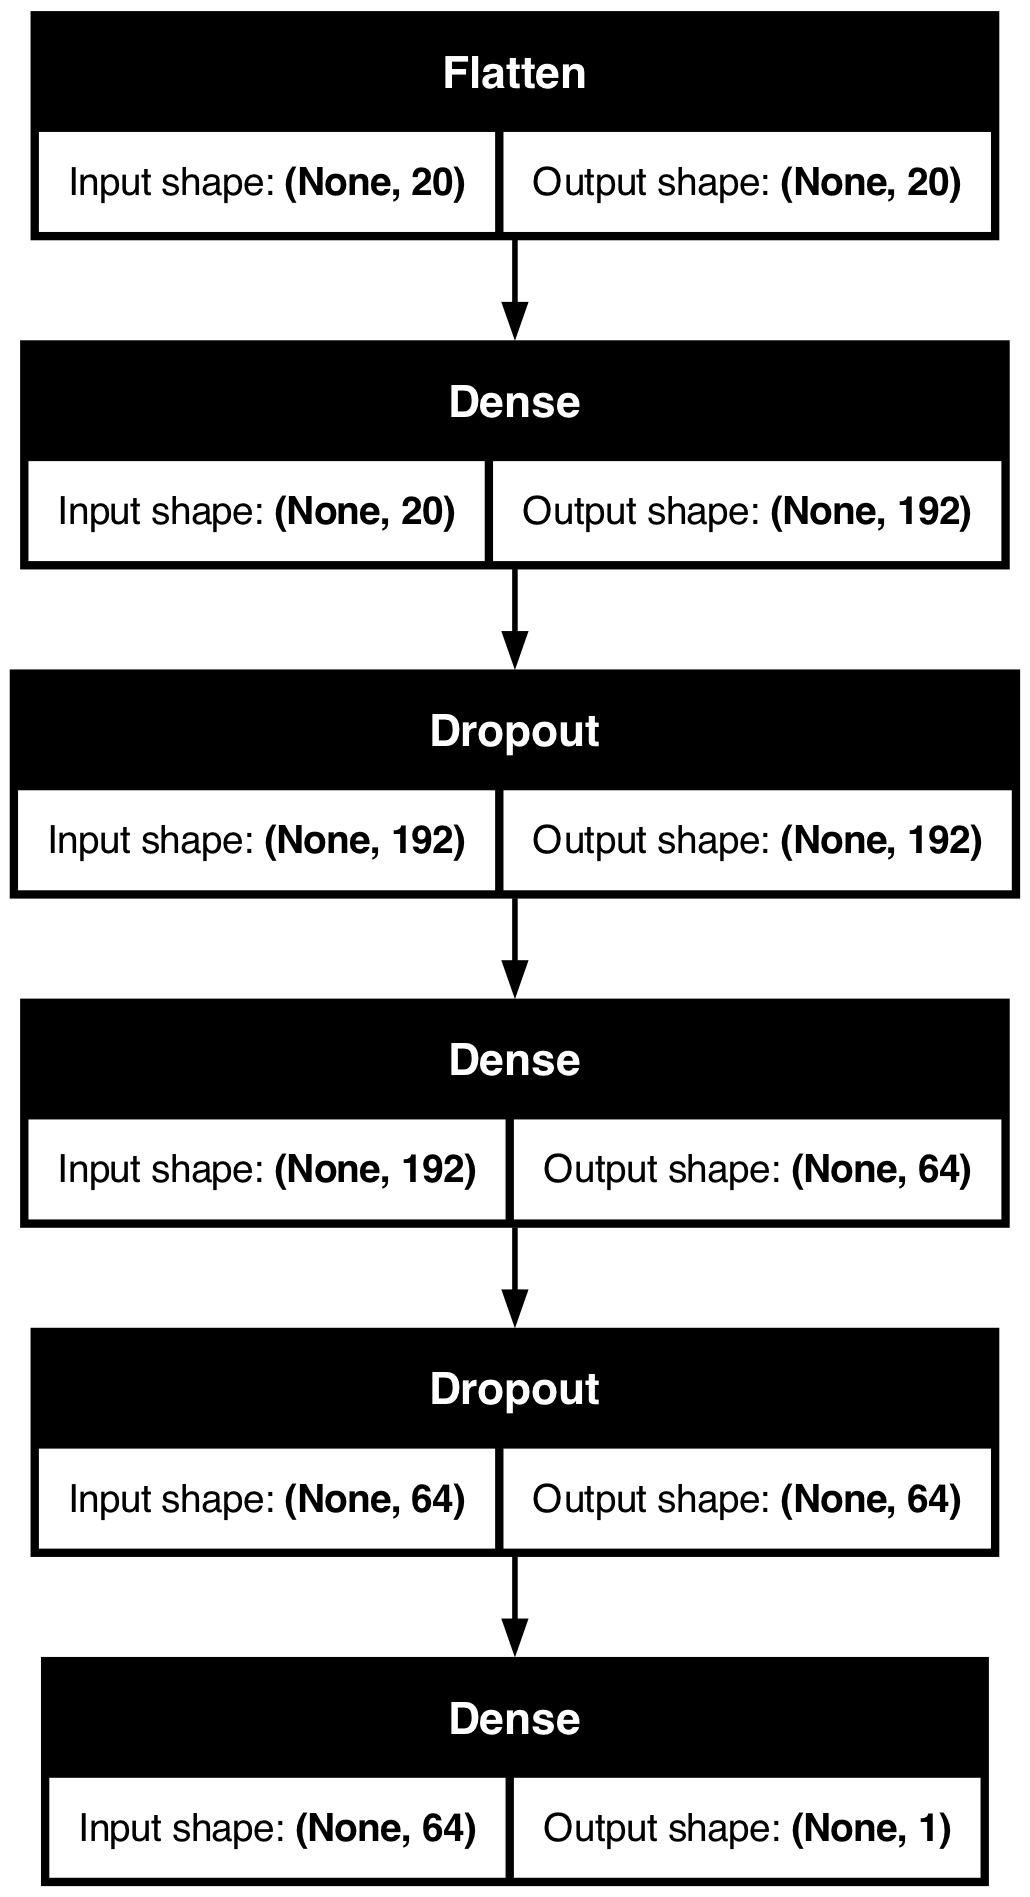

In [11]:
# plot the best model
best_model = tuner.get_best_models(num_models=1)[0]
keras.utils.plot_model(best_model, "my_fashion_mnist_model.png", show_shapes=True)



# 1. 

I had a problem where there was a shape mistmatch between my model's output and target labels.

```bash
ValueError: Arguments `target` and `output` must have the same shape. 
Received: target.shape=(None, 1), output.shape=(None, 10)
```

I solved this by add the last layer to give me a binary output for binary classification.

```python
tf.keras.layers.Dense(1, activation='sigmoid') 
```


# 2. 

I had the problem that i called: 
```python 
best_model = tuner.hypermodel.build(best_hps)
``` 
in cell 11, this create a new model with the best hyperparameters, but didn't contain the trained weights from my tuning process. This would lead to a different result than what I obtained in the tuning process. I fixed this by using 

```python
best_model = tuner.get_best_models(num_models=1)[0]
``` 

that reterived the actualy model instance that preformed best during tuning.


# 3. 
I had the problem that after the tuning i would obtain

```bash
Trial 20 Complete [00h 00m 03s]
val_precision: 0.7631579041481018
Best val_precision So Far: 0.7631579041481018
Total elapsed time: 00h 02m 22s
```

But when i re-ran the model i would get these results

```bash
Test Loss: 0.3034
Test Precision: 0.6768
Test Accuracy: 0.8446
Best validation precision: 0.6768 at epoch 11
```

This was because I essentially continuing training from where the tuning left off, which can lead to overfitting or different results. I fixed this by Evaluating the model without retraining.



# 4. 

I had the problem with data leakage where standard scaler would learn statistics (mean, variance) from the test data.

```python 
# For numerical features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test) 
```

I fixed this by changing `fit_transform()` to just `transform()`

```python
x_test = scaler.fit_transform(x_test) 
# to
x_test = scaler.transform(x_test) 
```

# 5.

I had the problem where I could not plot the hisotry from tuning the model in cell 9-11, I fixed this by creating a custom callback object that saved the history of each trying using a constructor. 

